In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset

import numpy as np
import pandas as pd

import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import nltk
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import re

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# 1. Select a dataset and preprocess

## 1.a. Read preprocess and print the main statistics


In [ ]:
df = pd.read_csv("Tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
df['airline'].unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

## 1.b. 3 visualization graphs related to your dataset.


https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py

### # of reviews positive, negative and neutral reviews on each airline

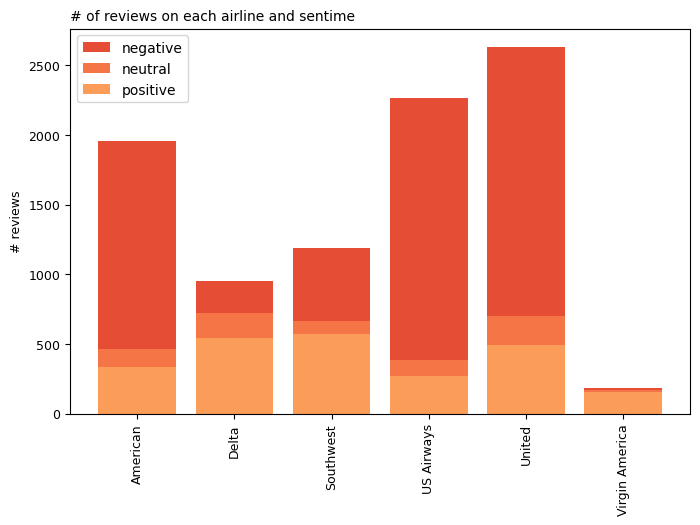

In [ ]:
group_table = df[['airline', 'airline_sentiment', 'tweet_id']].groupby(['airline', 'airline_sentiment']).count().reset_index()
pivot_df = group_table.pivot(index="airline", columns=['airline_sentiment'], values="tweet_id")
pivot_df


fig, ax = plt.subplots(figsize = (8, 5))

color = plt.colormaps['RdYlGn'](np.linspace(0.15, 0.85, 12))

for i, col in enumerate(pivot_df.columns):
    plt.bar(pivot_df.index, pivot_df[col], color = color[i], label = col)

ax.set_ylabel('# reviews', fontsize = 9)
ax.set_title('# of reviews on each airline and sentime', loc='left',  fontsize = 10)

ax.legend(loc='upper left', ncols=1)
plt.xticks(fontsize = 9, rotation=90)
plt.yticks(fontsize = 9)

plt.show()


### # of tweets in reason for negative review

In [ ]:
df['negativereason'].unique()

array([nan, 'Bad Flight', "Can't Tell", 'Late Flight',
       'Customer Service Issue', 'Flight Booking Problems',
       'Lost Luggage', 'Flight Attendant Complaints', 'Cancelled Flight',
       'Damaged Luggage', 'longlines'], dtype=object)

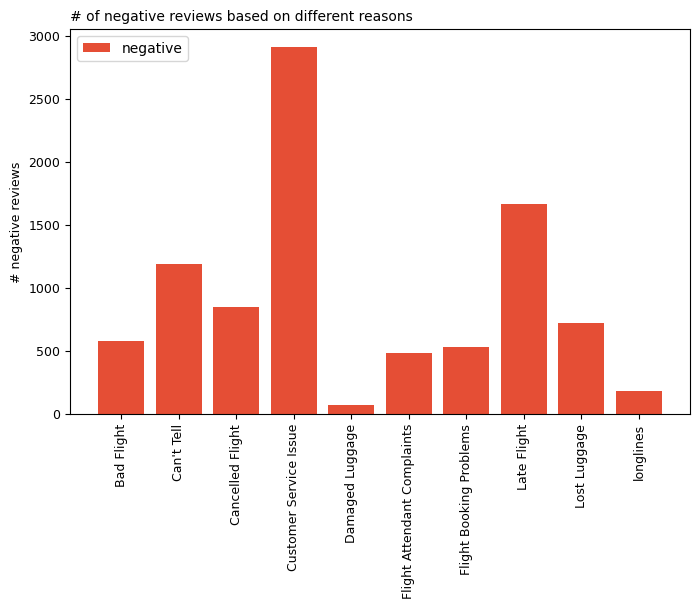

In [ ]:
group_table = df[['negativereason', 'airline_sentiment', 'tweet_id']].groupby(['negativereason', 'airline_sentiment']).count().reset_index()
pivot_df = group_table.pivot(index="negativereason", columns=['airline_sentiment'], values="tweet_id")

fig, ax = plt.subplots(figsize = (8, 5))

color = plt.colormaps['RdYlGn'](np.linspace(0.15, 0.85, 12))

for i, col in enumerate(pivot_df.columns):
    plt.bar(pivot_df.index, pivot_df[col], color = color[i], label = col)

ax.set_ylabel('# negative reviews', fontsize = 9)
ax.set_title('# of negative reviews based on different reasons', loc='left',  fontsize = 10)

ax.legend(loc='upper left', ncols=1)
plt.xticks(fontsize = 9, rotation=90)
plt.yticks(fontsize = 9)

plt.show()


### Word Cloud showing most frequent words in the tweets

https://python-graph-gallery.com/wordcloud/

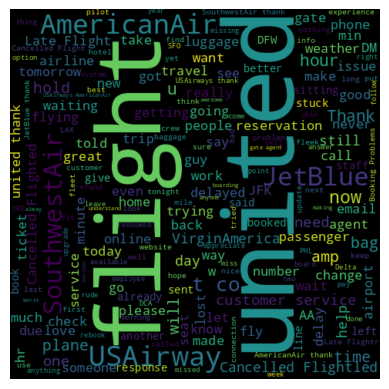

In [ ]:
from wordcloud import WordCloud

text = " ".join(df['text'].values)

wordcloud = WordCloud(width = 480, height = 480, margin=0).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [ ]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [ ]:
df_clean = df[['airline_sentiment', 'text']]
df_clean.isna().sum()

airline_sentiment    0
text                 0
dtype: int64

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   text               14640 non-null  object
dtypes: object(2)
memory usage: 228.9+ KB


## 1.a Preprocessing

### Encode the Data

In [ ]:
# encode values in airline_sentiment and airline
le_sentiment = preprocessing.LabelEncoder()
le_sentiment.fit(df_clean.loc[:, 'airline_sentiment'])
encoded_sentiment = le_sentiment.transform(df_clean['airline_sentiment'])

df_clean.loc[:, 'airline_sentiment'] = encoded_sentiment
df_clean.reset_index(drop=True, inplace=True)
df_clean.head()

<ipython-input-93-b7b43a73edaf>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.loc[:, 'airline_sentiment'] = encoded_sentiment
<ipython-input-93-b7b43a73edaf>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_clean.loc[:, 'airline_sentiment'] = encoded_sentiment


,airline_sentiment,text
0,1,@VirginAmerica What @dhepburn said.
1,2,@VirginAmerica plus you've added commercials t...
2,1,@VirginAmerica I didn't today... Must mean I n...
3,0,@VirginAmerica it's really aggressive to blast...
4,0,@VirginAmerica and it's a really big bad thing...


In [ ]:
a, b, c = df_clean['airline_sentiment'].value_counts()
print(a,b,c)

9178 3099 2363


### Maintain Class balance

In [ ]:
df_a = df_clean[df_clean['airline_sentiment'] == 0][:c]
df_b = df_clean[df_clean['airline_sentiment'] == 1][:c]
df_c = df_clean[df_clean['airline_sentiment'] == 2][:c]

In [ ]:
df_clean = pd.concat([df_a, df_b, df_c])

In [ ]:
df_clean['airline_sentiment'].value_counts()

0    2363
1    2363
2    2363
Name: airline_sentiment, dtype: int64

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In [ ]:
# removing emojis from the text

https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python

### Remove URLs, emojis and tags from the data

In [ ]:
def preprocess_text(tweet):
    link_re_pattern = "https?:\/\/t.co/[\w]+"
    mention_re_pattern = "@\w+"
    tweet = re.sub(link_re_pattern, "", tweet)
    tweet = re.sub(mention_re_pattern, "", tweet)

    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

    tweet = emoji_pattern.sub(r'', tweet)
    return tweet.lower()

In [ ]:
df_clean['text'] = df_clean['text'].apply(preprocess_text)

In [ ]:
train_clean_df, test_clean_df = train_test_split(df_clean, stratify = df_clean['airline_sentiment'], test_size=0.30)
test_clean_df, val_clean_df = train_test_split(test_clean_df, stratify = test_clean_df['airline_sentiment'], test_size=0.5)

word tokenize - https://www.kaggle.com/code/satishgunjal/tokenization-in-nlp

### Tokenize the data

In [ ]:
train_df_tokenize = [(sentiment, word_tokenize(tweet)) for sentiment, tweet in train_clean_df.values]
test_df_tokenize = [(sentiment, word_tokenize(tweet)) for sentiment, tweet in test_clean_df.values]
val_df_tokenize = [(sentiment, word_tokenize(tweet)) for sentiment, tweet in val_clean_df.values]

In [ ]:
sentence_padding = ["<PAD>", "<SOS>", "<EOS>"]

for d in [train_df_tokenize, test_df_tokenize, val_df_tokenize]:
    for sentiment, tweet in d:
        for token in tweet:
            if token not in sentence_padding:
                sentence_padding.append(token)

In [ ]:
word2index = {token: idx for idx, token in enumerate(sentence_padding)}
word2index["the"]


14

In [ ]:
seq_length = 32

In [ ]:
def encode_and_pad(tweet, length):
    sos = [word2index["<SOS>"]]
    eos = [word2index["<EOS>"]]
    pad = [word2index["<PAD>"]]

    if len(tweet) < length - 2:
        n_pads = length - 2 - len(tweet)
        encoded = [word2index[w] for w in tweet]
        return sos + encoded + eos + pad * n_pads
    else:
        encoded = [word2index[w] for w in tweet]
        truncated = encoded[:length - 2]
        return sos + truncated + eos

In [ ]:
train_encoded = [(encode_and_pad(tweet, seq_length), sentiment) for sentiment, tweet in train_df_tokenize]
val_encoded = [(encode_and_pad(tweet, seq_length), sentiment) for sentiment, tweet in val_df_tokenize]
test_encoded = [(encode_and_pad(tweet, seq_length), sentiment) for sentiment, tweet in test_df_tokenize]


In [ ]:
# Define the dataset class
class TextDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        text, sentiment = self.dataset[index]
        return torch.tensor(text), torch.tensor(sentiment)

    def __len__(self):
        return len(self.dataset)

In [ ]:
train_dataset = TextDataset(train_encoded)
val_dataset = TextDataset(test_encoded)
test_dataset = TextDataset(val_encoded)

batch_size = 32

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=batch_size, drop_last=True)

#2. Build LSTM

## a. Build the LSTM model architecture

In [ ]:
class LSTM_SentimentAnalysis(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden, dropout, num_layers = 1, classes = 3, bidi = False):
        super().__init__()
        self.hidden = hidden
        self.num_layers = num_layers
        self.bidi = bidi
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, self.hidden, self.num_layers, batch_first=True,  bidirectional = self.bidi)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(self.hidden * 2, classes) if bidi else nn.Linear(self.hidden, classes)

    def forward(self, x):
        embeddings = self.embedding(x)
        if self.bidi:
            hidden = (torch.zeros(self.num_layers * 2, batch_size, seq_length).to(device), torch.zeros(self.num_layers * 2, batch_size, seq_length).to(device))
        else:
            hidden = (torch.zeros(self.num_layers, batch_size, seq_length).to(device), torch.zeros(self.num_layers, batch_size, seq_length).to(device))
        out, hidden = self.lstm(embeddings, hidden)
        out = self.dropout(out)
        out = self.fc(out)
        out = out[:, -1]
        return out, hidden

In [ ]:
def val_model(model, criterion):
    val_loss = []
    val_acc = []
    for text, sentiment in val_loader:
        text = text.to(device)
        sentiment = sentiment.to(device)

        out, hidden = model(text)
        loss = criterion(out, sentiment)

        pred_proba = nn.Softmax(dim=1)(out)
        pred_proba = torch.argmax(pred_proba, dim=1)

        val_acc.append((pred_proba == sentiment).sum().item())
        val_loss.append(loss.item())

    val_acc = round(sum(val_acc) * 100/(len(val_loader) * batch_size), 4)
    val_loss = round(sum(val_loss)/(len(val_loader)), 4)
    return val_loss, val_acc


In [ ]:
def train_model(model, optimizer, criterion, n_epochs, early_stopping=True):
    training_acc = []
    validation_acc = []

    training_loss = []
    validation_loss = []

    best_loss = 99
    counter = 0
    threshold = 3
    for epoch in range(n_epochs):
        train_acc = []

        train_loss = []
        val_loss = []
        for text, sentiment in train_loader:
            text = text.to(device)
            sentiment = sentiment.to(device)

            optimizer.zero_grad()
            with torch.set_grad_enabled(True):

                out, hidden = model(text)
                pred_proba = nn.Softmax(dim=1)(out)
                pred_proba = torch.argmax(pred_proba, dim=1)

                train_acc.append((pred_proba == sentiment).sum().item())

                loss = criterion(out, sentiment)
                train_loss.append(loss.item())

                loss.backward()
                optimizer.step()

        train_acc = round(sum(train_acc) * 100/(len(train_loader)* batch_size), 4)
        train_loss = round(sum(train_loss)/(len(train_loader)), 4)

        training_acc.append(train_acc)
        training_loss.append(train_loss)

        val_loss, val_acc = val_model(model, criterion)
        validation_acc.append(val_acc)
        validation_loss.append(val_loss)

        print(f"Epoch: {epoch}, training loss: {train_loss}, accuracy: {train_acc}, validation loss: {val_loss}, accuracy: {val_acc}")

        # define early stopping
        if(early_stopping):
            if val_loss < best_loss:
                best_loss = val_loss
                best_model = model
                counter = 0
            else:
                counter += 1
                if(counter >= threshold):
                    print("Early Stopping Encounter")
                    break


    fig, ax = plt.subplots(1, 2, figsize = (12, 6))

    # plot training and validation accuracy
    ax[0].plot(range(0, epoch + 1), training_acc, label='Training Accuracy')
    ax[0].plot(range(0, epoch + 1), validation_acc, label='Validation Accuracy')
    ax[0].legend(loc = 'upper left')

    # plot training and validation loss
    ax[1].plot(range(0, epoch + 1), training_loss, label='Training Loss')
    ax[1].plot(range(0, epoch + 1), validation_loss, label='Validation Loss')
    ax[1].legend(loc = 'lower right')
    return model


## Train LSTM and report accuracy and loss

Epoch: 0, training loss: 1.1044, accuracy: 33.4274, validation loss: 1.1048, accuracy: 33.5227
Epoch: 1, training loss: 1.1033, accuracy: 33.4274, validation loss: 1.1037, accuracy: 33.6174
Epoch: 2, training loss: 1.1032, accuracy: 33.4073, validation loss: 1.103, accuracy: 33.428
Epoch: 3, training loss: 1.1029, accuracy: 33.2863, validation loss: 1.1038, accuracy: 33.3333
Epoch: 4, training loss: 1.1012, accuracy: 33.4476, validation loss: 1.1026, accuracy: 33.2386
Epoch: 5, training loss: 1.1013, accuracy: 33.4879, validation loss: 1.1012, accuracy: 33.428
Epoch: 6, training loss: 1.1004, accuracy: 33.4677, validation loss: 1.1018, accuracy: 33.6174
Epoch: 7, training loss: 1.1, accuracy: 33.4879, validation loss: 1.1001, accuracy: 33.428
Epoch: 8, training loss: 1.0998, accuracy: 33.75, validation loss: 1.1007, accuracy: 33.8068
Epoch: 9, training loss: 1.1, accuracy: 33.5685, validation loss: 1.0997, accuracy: 33.5227
Epoch: 10, training loss: 1.0988, accuracy: 33.8306, validatio

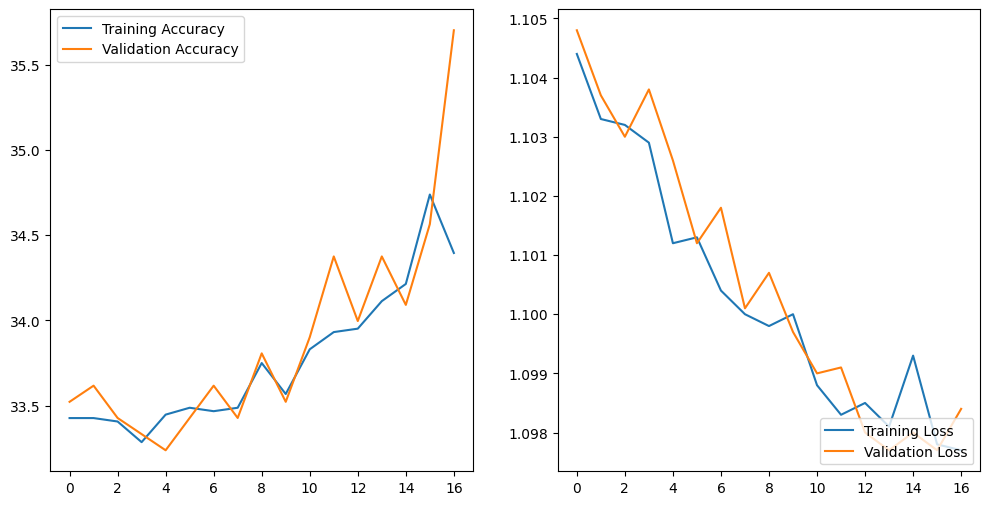

In [ ]:
biLSTM_model = LSTM_SentimentAnalysis(vocab_size = len(word2index),
                                      embedding_dim = 64,
                                      hidden = 32,
                                      dropout = 0.3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(biLSTM_model.parameters(), lr=0.0001, momentum=0.9)

n_epochs = 50

biLSTM_model = train_model(biLSTM_model, optimizer, criterion, n_epochs)

# 3. Different variations of LSTMs

## Bi-Directional LSTM

Epoch: 0, training loss: 1.0988, accuracy: 31.5121, validation loss: 1.0985, accuracy: 31.9129
Epoch: 1, training loss: 1.0989, accuracy: 31.7742, validation loss: 1.0984, accuracy: 31.9129
Epoch: 2, training loss: 1.0989, accuracy: 31.7742, validation loss: 1.0971, accuracy: 32.197
Epoch: 3, training loss: 1.0981, accuracy: 32.5202, validation loss: 1.0992, accuracy: 29.8295
Epoch: 4, training loss: 1.0976, accuracy: 32.9032, validation loss: 1.0956, accuracy: 35.7955
Epoch: 5, training loss: 1.0978, accuracy: 32.8024, validation loss: 1.0959, accuracy: 34.1856
Epoch: 6, training loss: 1.0973, accuracy: 33.4274, validation loss: 1.0962, accuracy: 33.8068
Epoch: 7, training loss: 1.0973, accuracy: 32.6613, validation loss: 1.0971, accuracy: 33.9015
Early Stopping Encounter


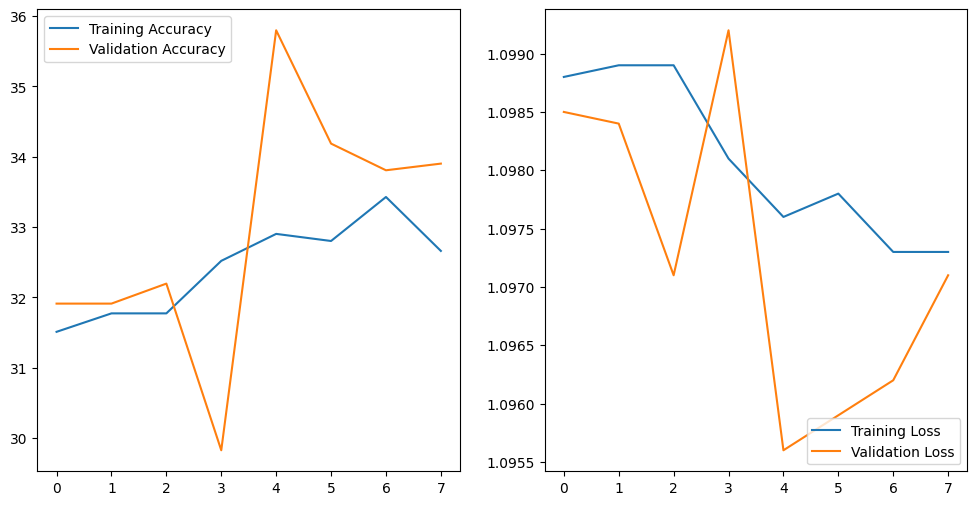

In [ ]:
biLSTM_model = LSTM_SentimentAnalysis(vocab_size = len(word2index),
                                      embedding_dim = 64,
                                      hidden = 32,
                                      dropout = 0.3,
                                      bidi = True).to(device) # bi-directional

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(biLSTM_model.parameters(), lr=0.0001, momentum=0.9)

n_epochs = 50

biLSTM_model = train_model(biLSTM_model, optimizer, criterion, n_epochs)

## Stacked LSTM (num_layers = 10)

Epoch: 0, training loss: 1.0992, accuracy: 33.2863, validation loss: 1.0995, accuracy: 34.8485
Epoch: 1, training loss: 1.0997, accuracy: 33.3669, validation loss: 1.099, accuracy: 33.0492
Epoch: 2, training loss: 1.099, accuracy: 34.0121, validation loss: 1.1002, accuracy: 32.5758
Epoch: 3, training loss: 1.0994, accuracy: 33.2258, validation loss: 1.0999, accuracy: 32.9545
Epoch: 4, training loss: 1.0989, accuracy: 34.0927, validation loss: 1.0994, accuracy: 33.9962
Early Stopping Encounter


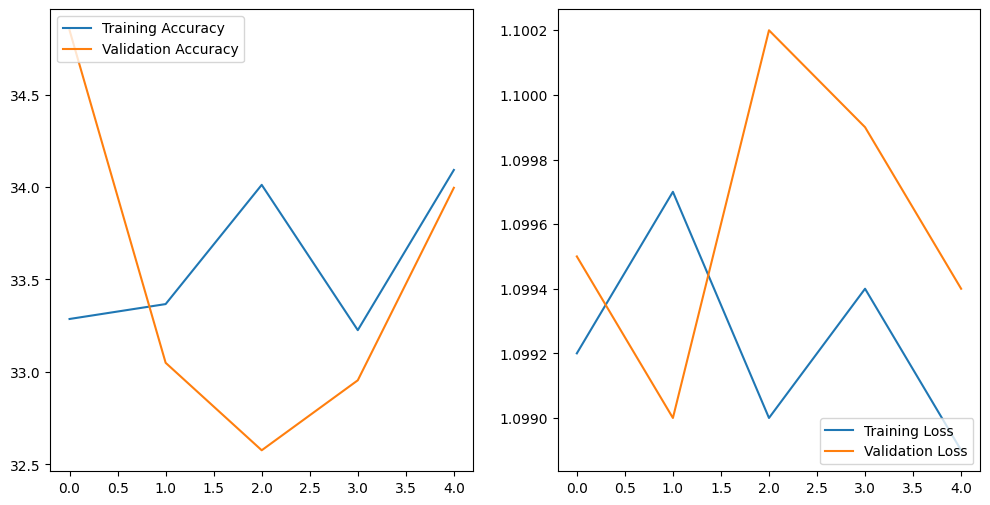

In [ ]:
biLSTM_model = LSTM_SentimentAnalysis(vocab_size = len(word2index),
                                      embedding_dim = 64,
                                      hidden = 32,
                                      num_layers = 10,  # Stacked LSTM
                                      dropout = 0.3,
                                      bidi = True).to(device) # bi-directional

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(biLSTM_model.parameters(), lr=0.0001, momentum=0.9)

n_epochs = 50

biLSTM_model = train_model(biLSTM_model, optimizer, criterion, n_epochs)


## GRU

In [ ]:
class GRU_SentimentAnalysis(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden, dropout, num_layers = 5, classes = 3):
        super().__init__()
        self.hidden = hidden
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, self.hidden, self.num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden, classes)

    def forward(self, x):
        embedded = self.embedding(x)
        hidden = torch.zeros(self.num_layers, batch_size, seq_length).to(device)
        out, _ = self.gru(embedded, hidden)
        out = self.dropout(out)
        out = self.fc(out)
        out = out[:, -1]
        return out, hidden


Epoch: 0, training loss: 1.1048, accuracy: 33.3266, validation loss: 1.105, accuracy: 33.3333
Epoch: 1, training loss: 1.1029, accuracy: 33.3266, validation loss: 1.1018, accuracy: 33.2386
Epoch: 2, training loss: 1.1024, accuracy: 33.4274, validation loss: 1.1044, accuracy: 33.1439
Epoch: 3, training loss: 1.1025, accuracy: 33.3266, validation loss: 1.101, accuracy: 32.8598
Epoch: 4, training loss: 1.1011, accuracy: 33.3266, validation loss: 1.1003, accuracy: 33.9015
Epoch: 5, training loss: 1.1012, accuracy: 33.0242, validation loss: 1.1019, accuracy: 32.7652
Epoch: 6, training loss: 1.1008, accuracy: 32.9032, validation loss: 1.1001, accuracy: 33.2386
Epoch: 7, training loss: 1.1001, accuracy: 33.2863, validation loss: 1.1001, accuracy: 34.2803
Epoch: 8, training loss: 1.0996, accuracy: 33.2056, validation loss: 1.0992, accuracy: 35.1326
Epoch: 9, training loss: 1.0992, accuracy: 33.3468, validation loss: 1.0995, accuracy: 31.4394
Epoch: 10, training loss: 1.0998, accuracy: 33.6492,

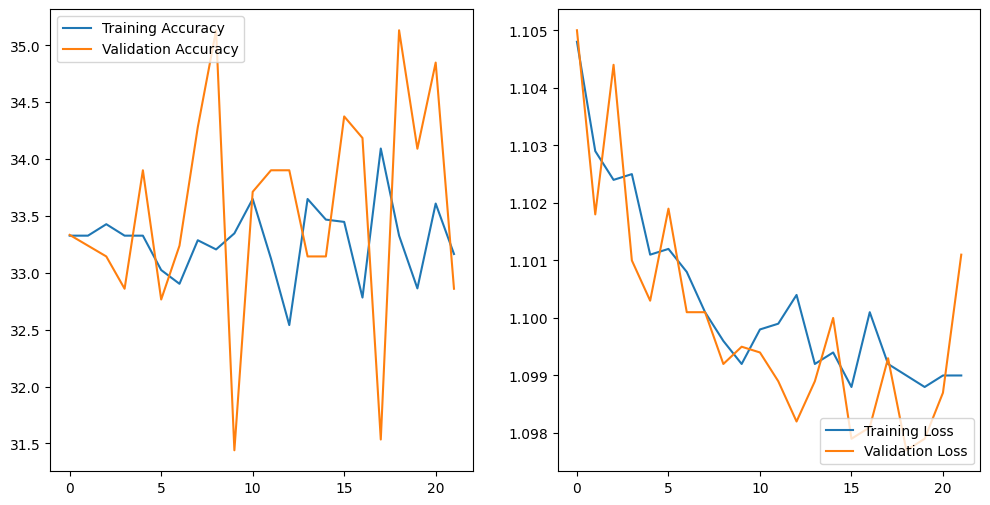

In [ ]:
GRU_model = GRU_SentimentAnalysis(vocab_size = len(word2index),
                                      embedding_dim = 64,
                                      hidden = 32,
                                      num_layers = 10,
                                      dropout = 0.3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(GRU_model.parameters(), lr=0.0001, momentum=0.9)

n_epochs = 50

GRU_model = train_model(GRU_model, optimizer, criterion, n_epochs)


## Using the best model to make the predictions on the test set

Loss:  1
              precision    recall  f1-score   support

           0       0.35      0.33      0.34       351
           1       0.37      0.47      0.41       352
           2       0.36      0.27      0.31       353

    accuracy                           0.36      1056
   macro avg       0.36      0.36      0.35      1056
weighted avg       0.36      0.36      0.35      1056



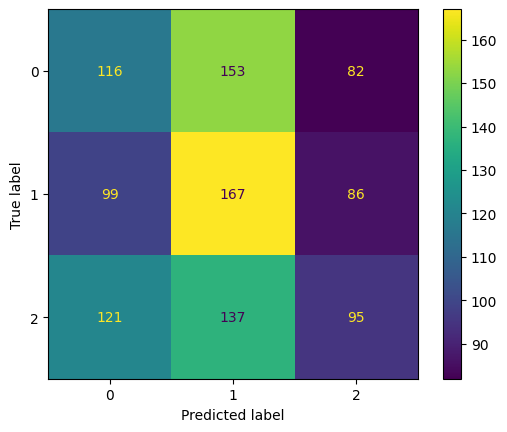

In [ ]:
test_loss = []

y_test = []
y_pred = []

with torch.no_grad():
    for text, sentiment in test_loader:
        text = text.to(device)
        sentiment = sentiment.to(device)

        out, hidden = GRU_model(text)
        loss = criterion(out, sentiment)

        pred_proba = nn.Softmax(dim=1)(out)
        pred_proba = torch.argmax(pred_proba, dim=1)

        y_test.append(sentiment.detach().to('cpu').numpy())
        y_pred.append(pred_proba.detach().to('cpu').numpy())

        test_loss.append(loss.item())

print("Loss: ", round(sum(test_loss)/len(test_loader)))

y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)

cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=1.0)

# display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
print(report)

disp.plot()
plt.show()



# Save model

In [ ]:
torch.save(GRU_model.state_dict(), './VIJAYAVA_CKONDINO_assignment2_part3.pth')